In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pyecharts.charts import Map,Bar,Grid,Scatter,Geo,Line,Boxplot,HeatMap
from pyecharts import options as opts
import seaborn as sns
from pyecharts.faker import Faker
from pyecharts.globals import ThemeType

In [2]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus']=False

# 1 数据导入

## 1.1 读取数据

In [3]:
data = pd.read_csv('./数据集/bj.csv', encoding='gbk')

## 1.2 对数据的列进行重命名

In [4]:
data = data.rename(columns={'简介': 'Introduction', '小区': 'Quarters', '户型': 'HouseType', '面积': 'Area',
                            '关注人数': 'PeopleNumber', '观看次数': 'WatchNumber', '发布时间': 'ReleaseTime',
                            '房价': 'TotalPrice', '单价/平': 'Price', '城区': 'Dist', '经纬度': 'Lotitude'})

## 1.3 数据预览

In [5]:
data.head()

,Introduction,Quarters,HouseType,Area,PeopleNumber,WatchNumber,ReleaseTime,TotalPrice,Price,Dist,Lotitude
0,户型方方正正 满五年就一套 视野开阔直观汇文中学,保利蔷薇,2室2厅,88.63平米,58人关注,共27次带看,19天以前发布,960.0,单价108316元/平米,东城,"116.442531,39.89667"
1,禾风相府 南北通透 三居室 前后花园 人车分流,禾风相府,3室2厅,163.83平米,247人关注,共115次带看,6个月以前发布,1801.0,单价109932元/平米,东城,"116.428303,39.929284"
2,金鱼池南北通透大复式 正对花园、视野好 诚心出售,金鱼池中区,4室2厅,135.91平米,166人关注,共54次带看,1个月以前发布,950.0,单价69900元/平米,东城,"116.415431,39.896044"
3,天娇园商品房 朝东2居 对小区花园 拎包入住,天娇园,2室2厅,91.48平米,61人关注,共41次带看,27天以前发布,850.0,单价92917元/平米,东城,"116.445751,39.903761"
4,南北通透三居室 和平里一小 中间楼层 满五年,和平里三区,2室1厅,71.92平米,39人关注,共51次带看,23天以前发布,800.0,单价111235元/平米,东城,"116.427002,39.962219"


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23440 entries, 0 to 23439
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Introduction  23440 non-null  object 
 1   Quarters      23440 non-null  object 
 2   HouseType     23440 non-null  object 
 3   Area          23440 non-null  object 
 4   PeopleNumber  23440 non-null  object 
 5   WatchNumber   23440 non-null  object 
 6   ReleaseTime   23440 non-null  object 
 7   TotalPrice    23440 non-null  float64
 8   Price         23440 non-null  object 
 9   Dist          23440 non-null  object 
 10  Lotitude      23440 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.0+ MB


# 2 数据的预处理

## 2.1 统一数据格式

#### 筛选房型、面积、关注人数、带看人数、发布时间、单价列中的中文

In [7]:
# 定义筛选中文字符的函数
def delete(cword):
    num = float(re.sub(r'[\u4e00-\u9fff]*\/*[\u4e00-\u9fff]','',cword))
    return num

# 定义筛选发布日期的函数
def reltime(data):
    days = re.findall(r'\d+天',data)
    months = re.findall(r'\d+个月',data)
    years = re.findall(r'\d+一年',data)
    if days:
        return int(re.sub(r'天','',days[0]))
    elif months:
        return 30*int(re.sub(r'个月','',months[0]))
    else:
        return 365
# 进行筛选    
data['Area']=data['Area'].apply(delete)
data['PeopleNumber']=data['PeopleNumber'].apply(delete)
data['WatchNumber']=data['WatchNumber'].apply(delete)
data['Price']=data['Price'].apply(delete)
data['ReleaseTime']=data['ReleaseTime'].apply(reltime)
# 数据预览
data.head()

,Introduction,Quarters,HouseType,Area,PeopleNumber,WatchNumber,ReleaseTime,TotalPrice,Price,Dist,Lotitude
0,户型方方正正 满五年就一套 视野开阔直观汇文中学,保利蔷薇,2室2厅,88.63,58.0,27.0,19,960.0,108316.0,东城,"116.442531,39.89667"
1,禾风相府 南北通透 三居室 前后花园 人车分流,禾风相府,3室2厅,163.83,247.0,115.0,180,1801.0,109932.0,东城,"116.428303,39.929284"
2,金鱼池南北通透大复式 正对花园、视野好 诚心出售,金鱼池中区,4室2厅,135.91,166.0,54.0,30,950.0,69900.0,东城,"116.415431,39.896044"
3,天娇园商品房 朝东2居 对小区花园 拎包入住,天娇园,2室2厅,91.48,61.0,41.0,27,850.0,92917.0,东城,"116.445751,39.903761"
4,南北通透三居室 和平里一小 中间楼层 满五年,和平里三区,2室1厅,71.92,39.0,51.0,23,800.0,111235.0,东城,"116.427002,39.962219"


## 2.2 分割经纬度 

#### 分割数据列中的经纬度为经度、纬度 

In [8]:
# 获取经纬度列
Lotitude = data['Lotitude']
# 初始化经度列、纬度列
Longitude = np.array(np.arange(len(Lotitude)),dtype=str)
Latitude = np.array(np.arange(len(Lotitude)),dtype=str)
# 分割数据并插入
for i in Lotitude.index:
    Longitude[i] = Lotitude[i].split(',',1)[0]
    Latitude[i] = Lotitude[i].split(',',1)[-1]
# 添加列
data['Longitude'] = Longitude
data['Latitude'] = Latitude

data.head()

,Introduction,Quarters,HouseType,Area,PeopleNumber,WatchNumber,ReleaseTime,TotalPrice,Price,Dist,Lotitude,Longitude,Latitude
0,户型方方正正 满五年就一套 视野开阔直观汇文中学,保利蔷薇,2室2厅,88.63,58.0,27.0,19,960.0,108316.0,东城,"116.442531,39.89667",116.442531,39.89667
1,禾风相府 南北通透 三居室 前后花园 人车分流,禾风相府,3室2厅,163.83,247.0,115.0,180,1801.0,109932.0,东城,"116.428303,39.929284",116.428303,39.929284
2,金鱼池南北通透大复式 正对花园、视野好 诚心出售,金鱼池中区,4室2厅,135.91,166.0,54.0,30,950.0,69900.0,东城,"116.415431,39.896044",116.415431,39.896044
3,天娇园商品房 朝东2居 对小区花园 拎包入住,天娇园,2室2厅,91.48,61.0,41.0,27,850.0,92917.0,东城,"116.445751,39.903761",116.445751,39.903761
4,南北通透三居室 和平里一小 中间楼层 满五年,和平里三区,2室1厅,71.92,39.0,51.0,23,800.0,111235.0,东城,"116.427002,39.962219",116.427002,39.962219


##  2.3 处理缺失值

In [9]:
# 统计缺失值的数量
data.isnull().sum()

Introduction    0
Quarters        0
HouseType       0
Area            0
PeopleNumber    0
WatchNumber     0
ReleaseTime     0
TotalPrice      0
Price           0
Dist            0
Lotitude        0
Longitude       0
Latitude        0
dtype: int64

#### 经统计，该组数据不存在缺失值

## 2.4 处理重复值

In [10]:
# 删除重复行
data.drop_duplicates(inplace = True)
# 重置index
data.reset_index(inplace = True,drop = True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22152 entries, 0 to 22151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Introduction  22152 non-null  object 
 1   Quarters      22152 non-null  object 
 2   HouseType     22152 non-null  object 
 3   Area          22152 non-null  float64
 4   PeopleNumber  22152 non-null  float64
 5   WatchNumber   22152 non-null  float64
 6   ReleaseTime   22152 non-null  int64  
 7   TotalPrice    22152 non-null  float64
 8   Price         22152 non-null  float64
 9   Dist          22152 non-null  object 
 10  Lotitude      22152 non-null  object 
 11  Longitude     22152 non-null  object 
 12  Latitude      22152 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 2.2+ MB


#### 经过删除后，该组数据剩余数据22153条

# 3 数据的可视化分析

## 3.1 区域和房价的关系

## 3.1.1 区域内二手房的分布情况

In [12]:
# 获取各个区域的二手房数量（已排序）
x = data['Dist'].value_counts().index.tolist()
y = data['Dist'].value_counts().tolist()
# 绘制柱状图
bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(x)
    .add_yaxis("数量", y)
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市二手房的区域分布情况"),
                     yaxis_opts=opts.AxisOpts(name="二手房数量(单位:套)"),
                     xaxis_opts=opts.AxisOpts(name="区域",axislabel_opts={"rotate":45})
                    )
)
bar.render_notebook()

## 2.1.2 查看各个城区的房屋单价分布

In [13]:
# 构建一个dataframe
x = data['Dist'].unique()
y = np.arange(len(x))

for i in range(len(x)):
    price = data[data['Dist']==x[i]]['Price'].mean()
    y[i]=price

price = pd.DataFrame({'区域': x,
    '价格 (元/平米)': y})
price

,区域,价格 (元/平米)
0,东城,94046
1,西城,103131
2,朝阳,71149
3,海淀,85772
4,丰台,59536
5,石景山,54666
6,通州,50911
7,昌平,43349
8,大兴,46912
9,亦庄开发区,46081


In [14]:
# 绘制按地区分平均每平米的价格的柱状图
plt.figure(figsize=(20,10))

bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(x.tolist())
    .add_yaxis("价格", y.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市二手房各个地区的平均房价对比"),
                     yaxis_opts=opts.AxisOpts(name="二手房价格(单位:元)"),
                     xaxis_opts=opts.AxisOpts(name="区域",axislabel_opts={"rotate":45})
                    )
)
bar.render_notebook()

<Figure size 1440x720 with 0 Axes>

In [15]:
# 绘制各个城区房屋总价的热力图

# 处理区域的名字
price['区域']=price['区域']+'区'

city = (
    Map(init_opts=opts.InitOpts(width = '1200px', height='700px'))
    .add("",
         price.values,
         "北京")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="北京市平均房价图"),
        visualmap_opts=opts.VisualMapOpts(
            min_=100,
            max_=200,
            is_piecewise=True,
            pieces=[
                {"min": 100000, "label": '>100000元/平米', "color": "#0000CD"},
                {"min": 80000, "max": 100000, "label": '80000-100000元/平米', "color": "#1E90FF"},
                {"min": 60000, "max": 80000, "label": '60000-80000元/平米', "color": "#1C86EE"},
                {"min": 40000, "max": 60000, "label": '40000-60000元/平米', "color": "#1874CD"},
                {"min": 0, "max": 40000, "label": '<40000元/平米', "color": "#63B8FF"}
            ],
            range_text=['高', '低']
        )
    )
)
city.render_notebook()

### 2.1.3 查看各个城区的房屋总价分布情况

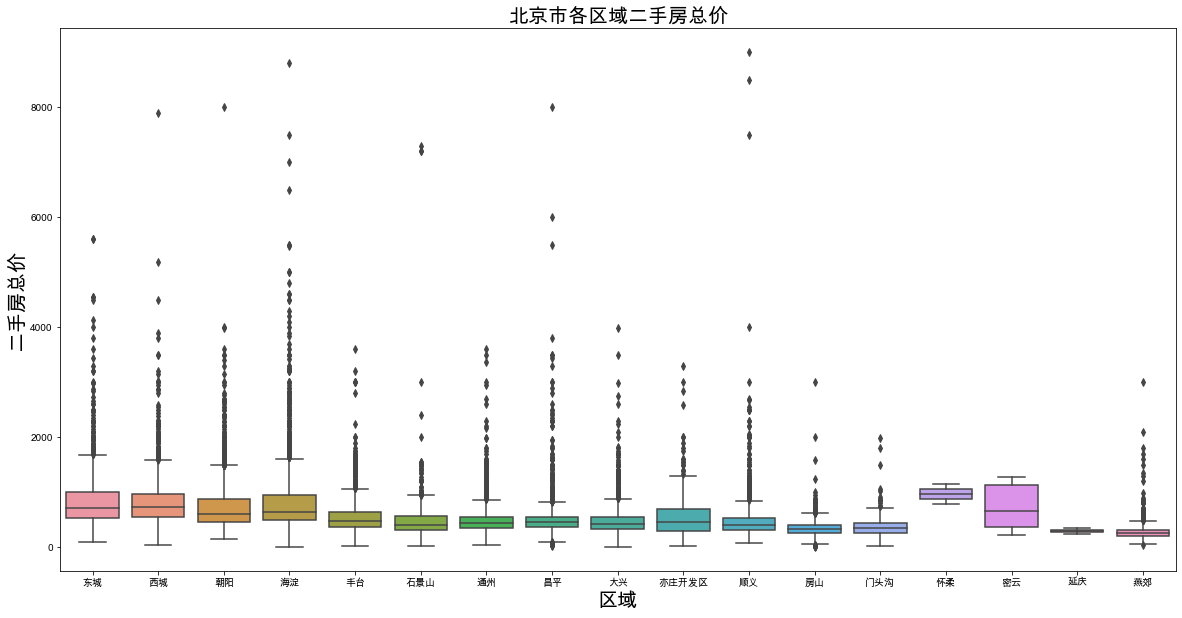

In [16]:
# 绘制各个城区房屋总价的箱线图
plt.figure(figsize = (20, 10))
sns.boxplot(x='Dist',y='TotalPrice',data=data)
plt.xlabel('区域', fontsize=20) 
plt.ylabel('二手房总价', fontsize=20)
plt.title('北京市各区域二手房总价',size=20)
plt.show()

In [17]:
data['TotalPrice'].describe()

count    22152.000000
mean       589.524458
std        450.074229
min         15.000000
25%        350.000000
50%        482.000000
75%        675.250000
max       9000.000000
Name: TotalPrice, dtype: float64

## 2.2 小区与房价的关系

### 2.2.1 小区房源数量分布

In [18]:
quarter = data['Quarters'].value_counts().to_frame().reset_index()
quarter

,index,Quarters
0,福城上上城五期,158
1,福城上上城三季,115
2,纳丹堡,101
3,星河皓月,97
4,天通苑东一区,92
...,...,...
4303,峻峰华亭,1
4304,玉石胡同,1
4305,吴店西里,1
4306,三虎桥南路25号院,1


#### 共4308个小区，其中府城上上城的房源数量较多

### 2.2.2 小区总房价对比

In [19]:
quarters = data['Quarters'].unique()
price = np.arange(len(quarters))

for i in range(len(quarters)):
    p = data[data['Quarters']==quarters[i]]['TotalPrice'].mean()
    price[i]=p

xiaoqu = pd.DataFrame({'小区': quarters,
    '价格(万元)': price})

# 按照价格排序
xiaoqu = xiaoqu.sort_values(by="价格(万元)",ascending=False)

xiaoqu

,小区,价格(万元)
1466,东山墅,8000
3994,优山美地B区,8000
670,新文化街四合院,7900
1983,香山清琴,7000
3884,丽宫,6500
...,...,...
4081,加州水郡金桥国际酒店,87
715,丽华苑,80
3420,逸品尚枫,60
4042,加州水郡Q酷,59


In [20]:
# 获取房价前五名的总房价
q5 = xiaoqu.head(5)
x = q5['小区']
y = q5['价格(万元)']

bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(x.tolist())
    .add_yaxis("价格", y.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市小区平均房价前五名"),
                    yaxis_opts=opts.AxisOpts(name="房价"),
                     xaxis_opts=opts.AxisOpts(name="小区名称"))
)
bar.render_notebook()

## 2.3 面积与价格的关系

In [21]:
area = data['Area']
HouseType = data['HouseType']
price = data['TotalPrice']
dist = data['Dist']
Longitude = data['Longitude'] 
Latitude = data['Latitude'] 

ap = pd.DataFrame({'面积': area,
                   '房型':HouseType,
                   '区域':dist,
                   '价格':price})

### 2.3.1 各面积区间内的房屋数量

In [22]:
x1 = ['<50','50-100','100-150','150-200','200-250','>250']
y1 = np.zeros(6)

for i in range(len(area)):
    if area[i] <=50:
        y1[0] += 1
        continue
    if area[i] <=100:
        y1[1] += 1
        continue
    if area[i] <=150:
        y1[2] += 1
        continue
    if area[i] <=200:
        y1[3] += 1
        continue
    if area[i] <=250:
        y1[4] += 1
        continue
    if area[i] >250:
        y1[5] += 1

bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(x1)
    .add_yaxis("数量", y1.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市二手房面积/数量统计"),
                    yaxis_opts=opts.AxisOpts(name="数量"),
                     xaxis_opts=opts.AxisOpts(name="面积区间"))
)
bar.render_notebook()

### 2.3.2 面积与价格的关系

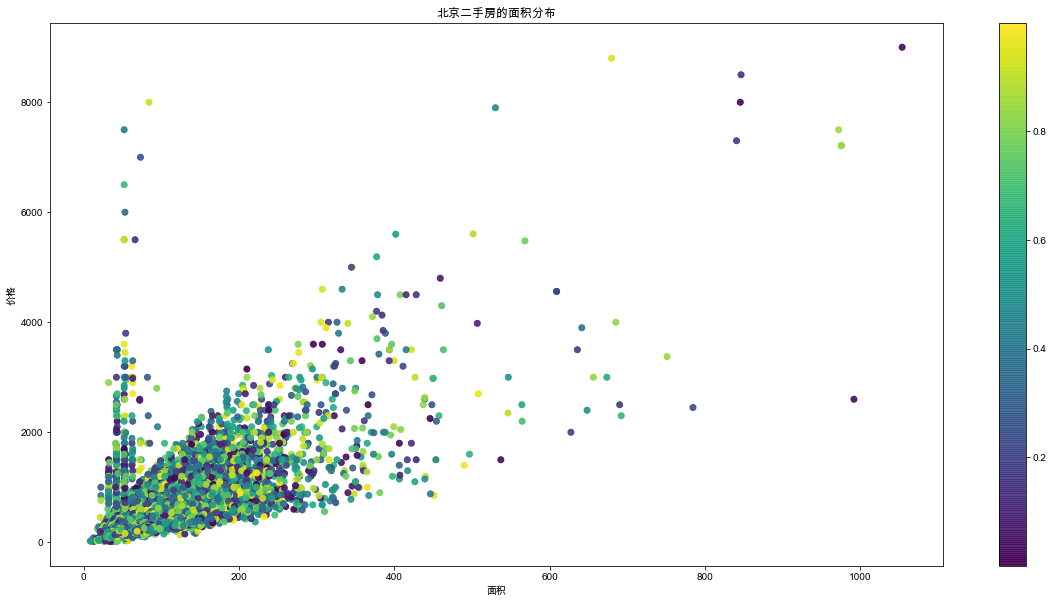

In [23]:
plt.figure(figsize=(20,10))
rng = np.random.RandomState(0)
colors = rng.rand(22152)
plt.scatter(area, price,c=colors,alpha = 0.9)
plt.colorbar()
plt.title('北京二手房的面积分布')
plt.xlabel('面积')
plt.ylabel('价格')
plt.show()

## 2.4 户型与价格的关系

## 2.4.1 不同户型的数量

In [24]:
HouseType.value_counts().to_frame().reset_index()

,index,HouseType
0,2室1厅,8313
1,3室1厅,3161
2,1室1厅,2790
3,3室2厅,2739
4,2室2厅,1876
5,1室0厅,1128
6,4室2厅,775
7,4室1厅,228
8,5室2厅,192
9,联排别墅,114


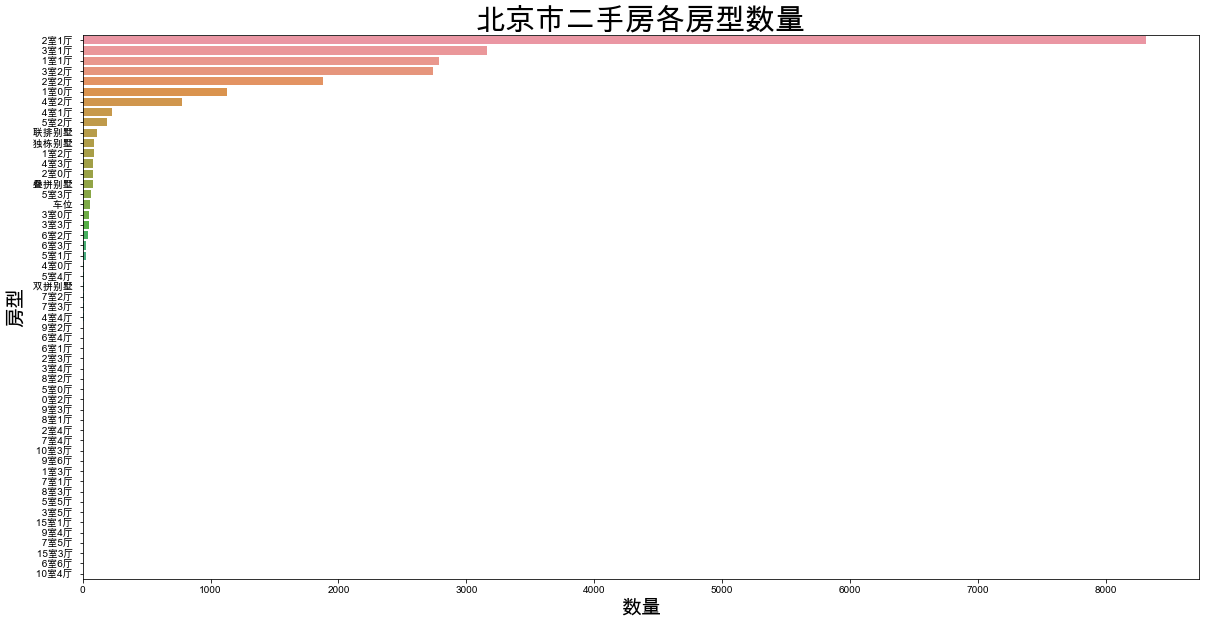

In [25]:
HouseNum = HouseType.value_counts().to_frame().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(y='index',x='HouseType',data=HouseNum)
plt.title('北京市二手房各房型数量',size=30)
plt.ylabel('房型',size=20)
plt.xlabel('数量',size=20)
plt.show()

### 2.4.2 不同户型的总价

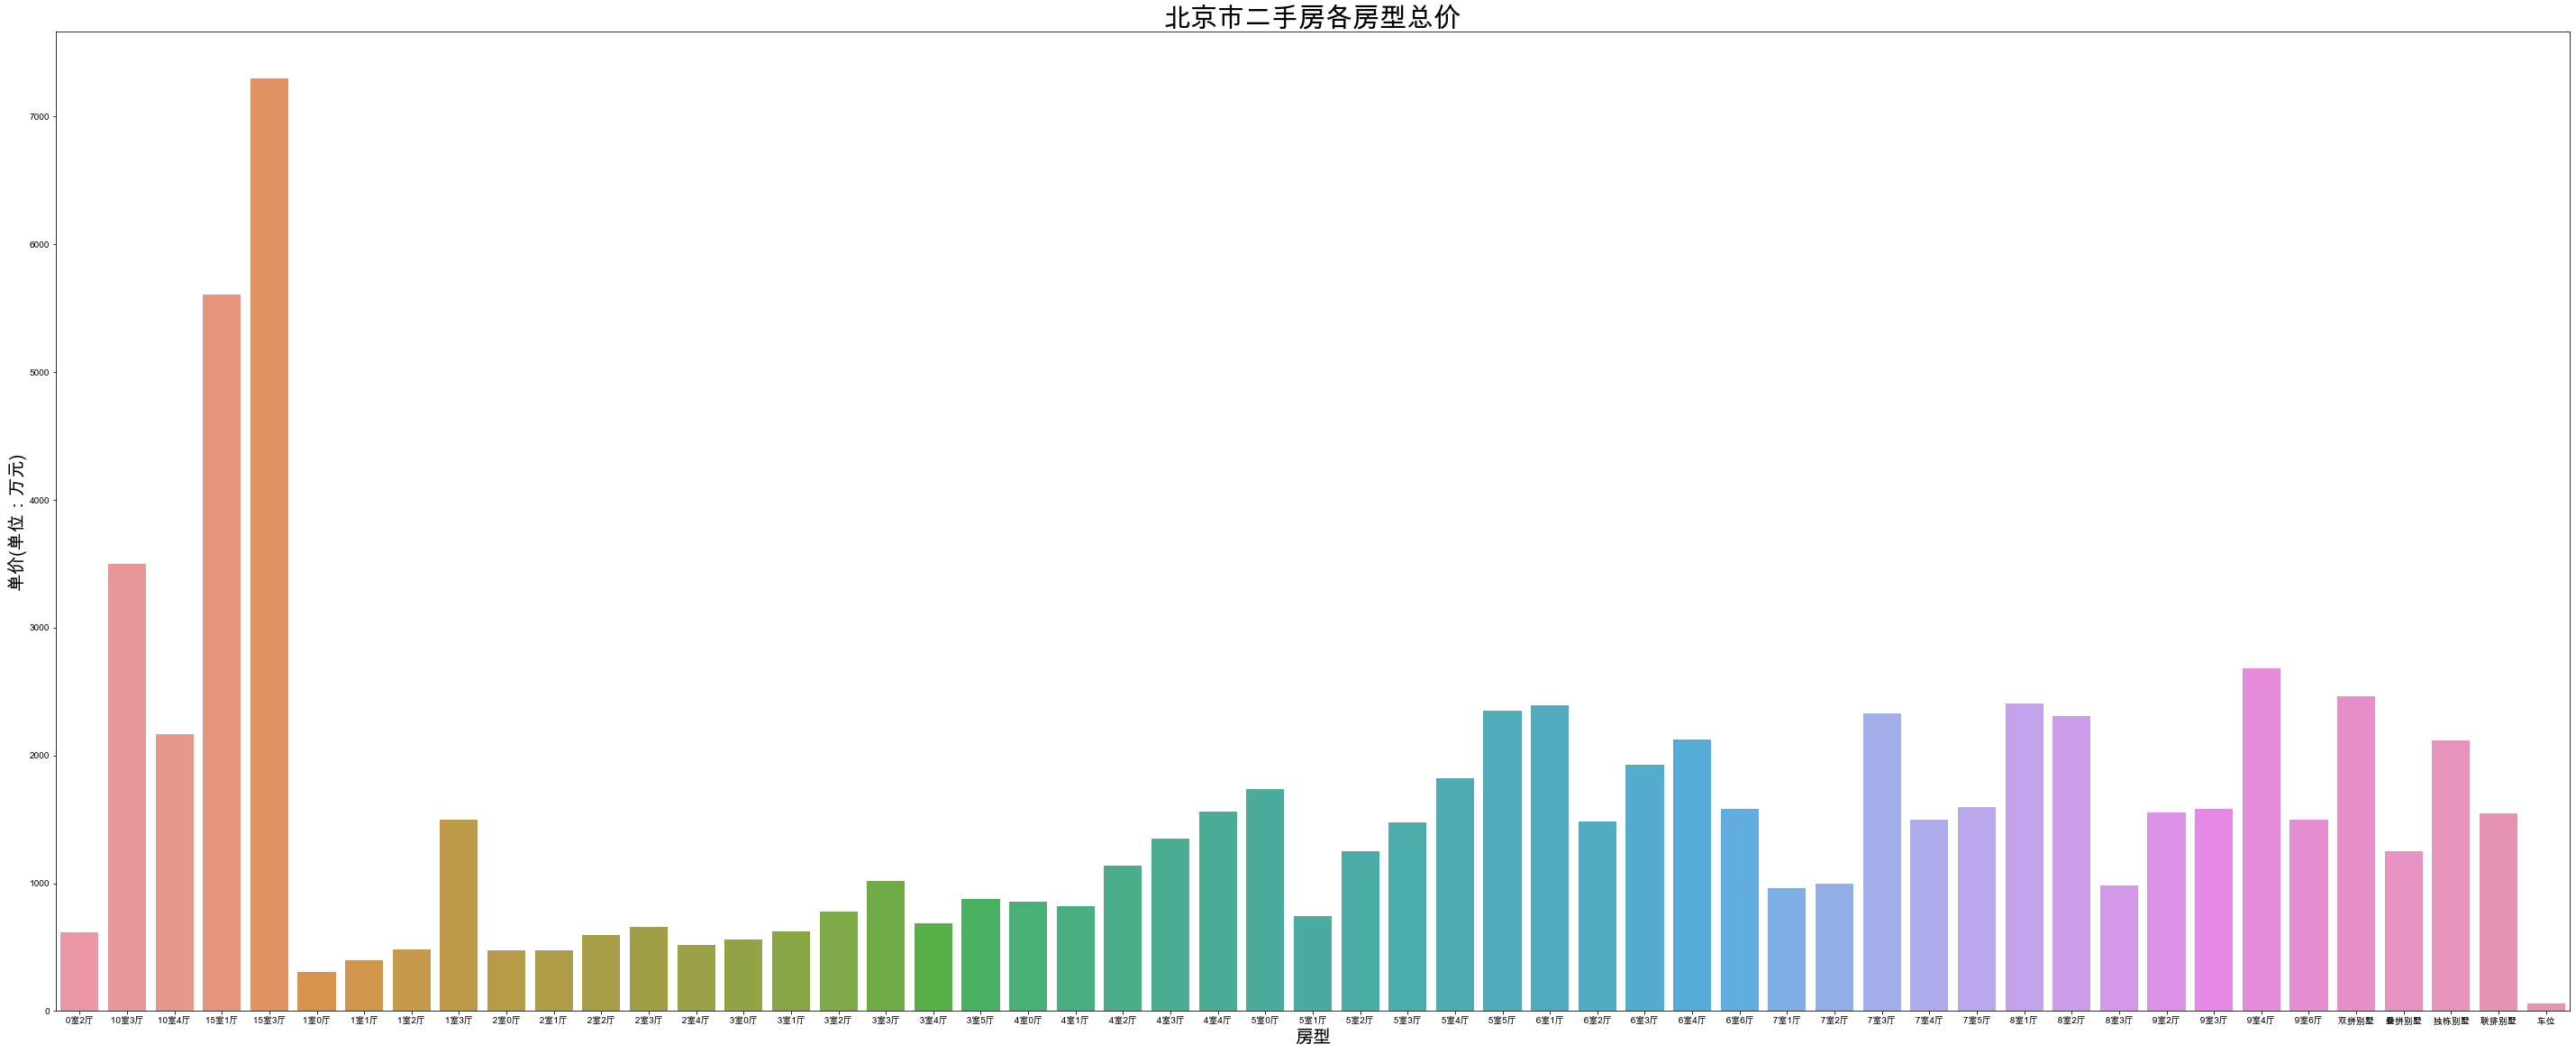

In [26]:
# 获取数据
HousePrice = data.groupby(['HouseType'])['TotalPrice'].mean().to_frame().reset_index()
plt.figure(figsize=(50,20))
sns.barplot(x='HouseType',y='TotalPrice',data=HousePrice)
plt.title('北京市二手房各房型总价',size=30)
plt.xlabel('房型',size=20)
plt.ylabel('单价(单位：万元)',size=20)
plt.show()

## 2.5 热度和观看人数分析

## 2.5.1 热度和房价的关系

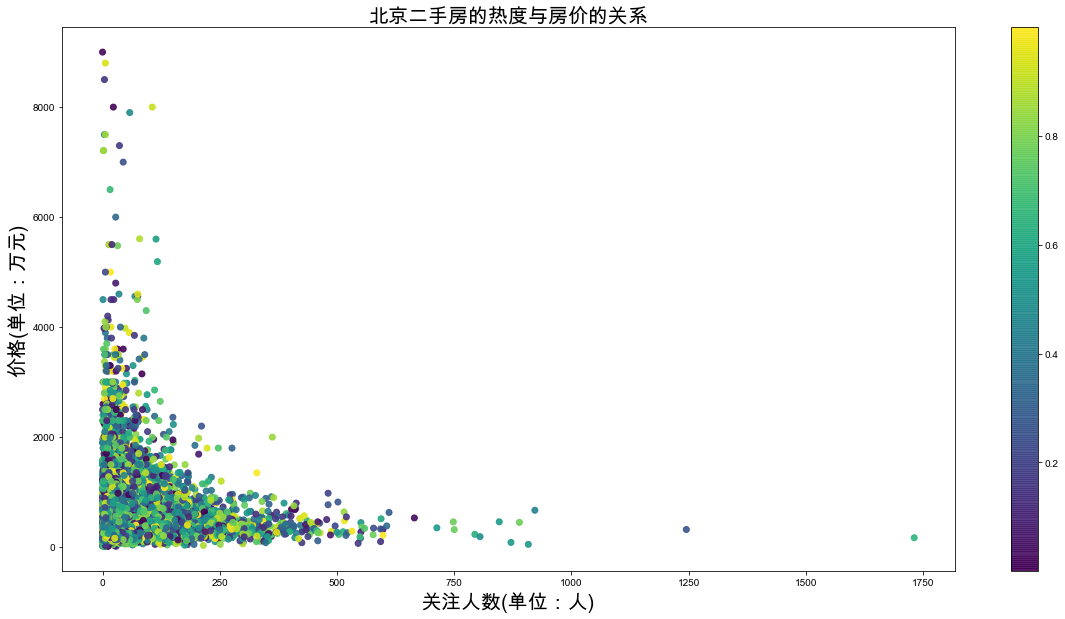

In [27]:
plt.figure(figsize=(20,10))
rng = np.random.RandomState(0)
colors = rng.rand(22152)
plt.scatter(data.PeopleNumber, data.TotalPrice,c=colors,alpha = 0.9)
plt.colorbar()
plt.title('北京二手房的热度与房价的关系',size=20)
plt.xlabel('关注人数(单位：人)',size=20)
plt.ylabel('价格(单位：万元)',size=20)
plt.show()

In [28]:
data.sort_values(by='PeopleNumber',ascending=False).head()

,Introduction,Quarters,HouseType,Area,PeopleNumber,WatchNumber,ReleaseTime,TotalPrice,Price,Dist,Lotitude,Longitude,Latitude
19408,北潞春家园 1室1厅 170万,北潞春家园,1室1厅,66.34,1731.0,36.0,150,170.0,25626.0,房山,"116.134573,39.746639",116.134573,39.746639
13774,满五，全西向两居， 楼层高，视野好,天通西苑三区,2室1厅,92.92,1245.0,38.0,150,320.0,34439.0,昌平,"116.416156,40.082585",116.416156,40.082585
1569,车公庄北里南北通透三居 明厨明卫 下楼就是地铁,车公庄北里,3室1厅,82.80,922.0,366.0,120,670.0,80918.0,西城,"116.353434,39.940291",116.353434,39.940291
13717,原值40 花5万精装 上下已打通 直接拎包入住,北街家园五区,1室1厅,18.00,908.0,275.0,90,50.0,27778.0,昌平,"116.270635,40.172195",116.270635,40.172195
13298,商品房满五年 首套房只交1.5契税 自住装修 诚售,龙跃苑一区,2室2厅,98.57,889.0,39.0,365,450.0,45653.0,昌平,"116.358797,40.083529",116.358797,40.083529


## 2.5.2 观看人数和房价的关系

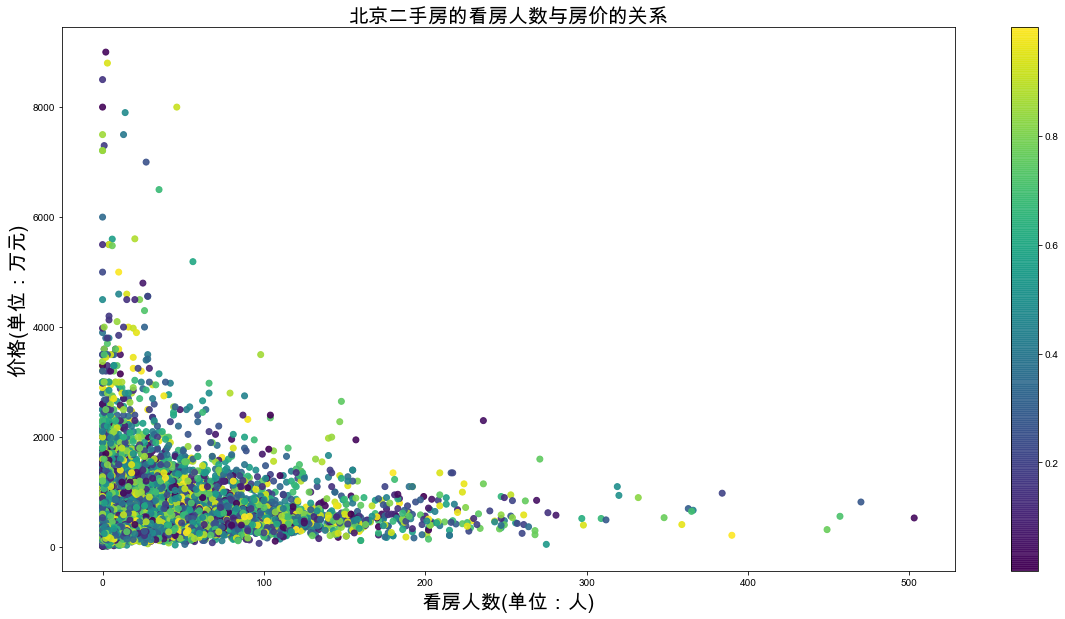

In [29]:
plt.figure(figsize=(20,10))
rng = np.random.RandomState(0)
colors = rng.rand(22152)
plt.scatter(data.WatchNumber, data.TotalPrice,c=colors,alpha = 0.9)
plt.colorbar()
plt.title('北京二手房的看房人数与房价的关系',size=20)
plt.xlabel('看房人数(单位：人)',size=20)
plt.ylabel('价格(单位：万元)',size=20)
plt.show()

In [30]:
data.sort_values(by='WatchNumber',ascending=False).head()

,Introduction,Quarters,HouseType,Area,PeopleNumber,WatchNumber,ReleaseTime,TotalPrice,Price,Dist,Lotitude,Longitude,Latitude
2413,满五年，南向，带露台，业主诚售,万象新天四区,2室1厅,93.80,665.0,503.0,90,530.0,56504.0,朝阳,"116.598911,39.932527",116.598911,39.932527
3777,高层观景三居 新房没住过 南北通透,世纪龙祥嘉园,3室2厅,121.64,502.0,470.0,150,820.0,67413.0,朝阳,"116.409861,40.042394",116.409861,40.042394
5560,志新北里 南北通透两居室 精装修 格局方正,志新北里,2室1厅,61.40,107.0,457.0,120,560.0,91206.0,海淀,"116.373007,39.999454",116.373007,39.999454
12915,顶层带露台，简单装修，南北通透一居室，,名佳花园三区,1室1厅,67.00,750.0,449.0,365,318.0,47463.0,昌平,"116.425304,40.112553",116.425304,40.112553
12907,精装小户型，面对小区，安静宜居,东亚上北中心,1室1厅,57.00,598.0,390.0,90,215.0,37720.0,昌平,"116.347998,40.087773",116.347998,40.087773


## 2.6 发布时间和价格的关系

### 2.6.1 不同发布时间的房屋数量

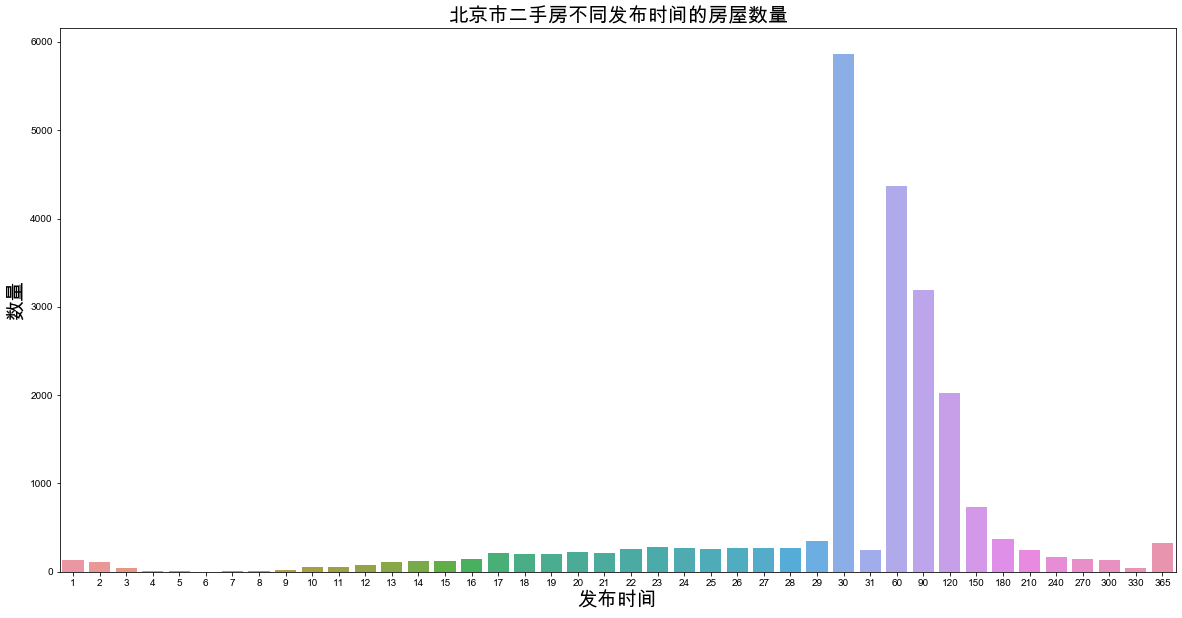

In [31]:
Time = data['ReleaseTime'].value_counts().to_frame().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(x='index',y='ReleaseTime',data=Time)
plt.title('北京市二手房不同发布时间的房屋数量',size=20)
plt.ylabel('数量',size=20)
plt.xlabel('发布时间',size=20)
plt.show()

### 2.6.2 不同发布时间的房屋总价

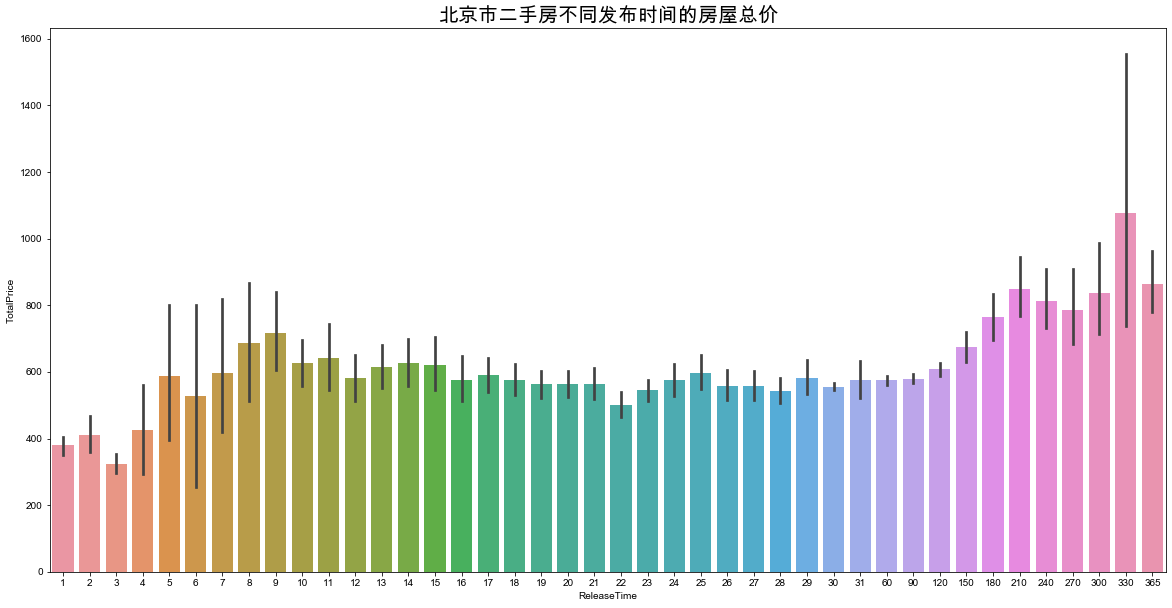

In [32]:
plt.figure(figsize=(20,10))
sns.barplot(x='ReleaseTime',y='TotalPrice',data=data)
plt.title('北京市二手房不同发布时间的房屋总价',size=20)
plt.show()

### 2.6.3 发售时间超过一年的房子区域分布

In [33]:
house = data[data['ReleaseTime']==365]
house.index = np.arange(len(house))

In [34]:
dist = house['Dist'].unique()
num = np.zeros(len(dist))

for i in range(len(house)):
    for j in range(len(dist)):
        if house.iloc[i,:]['Dist']==dist[j]:
            num[j] += 1


bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(dist.tolist())
    .add_yaxis("数量", num.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市二手房超过一年房子的区域分布情况"),
                     yaxis_opts=opts.AxisOpts(name="二手房数量(单位:套)"),
                     xaxis_opts=opts.AxisOpts(name="区域",axislabel_opts={"rotate":45})
                    )
)
bar.render_notebook()

### 2.6.4 发售时间超过一年的房子总价

In [35]:
price = np.zeros(len(dist))

for i in range(len(house)):
    for j in range(len(dist)):
        if house.iloc[i,:]['Dist']==dist[j]:
            price[j] += house.iloc[i,:]['TotalPrice']

for i in range(len(num)):
    price[i] = round(price[i]/num[i],2)
    
bar = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(dist.tolist())
    .add_yaxis("数量", price.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title="北京市二手房超过一年房子的各个区域的总价情况"),
                     yaxis_opts=opts.AxisOpts(name="价格(单位:元)"),
                     xaxis_opts=opts.AxisOpts(name="区域",axislabel_opts={"rotate":45})
                    )
)
bar.render_notebook()

# 3 模型建立

## 3.1 数据预处理

### 3.1.1 将户型列进行分解

#### 别墅房型设为0、1、2、3，车库设为4

In [36]:
data.loc[:,'BigHouse0'] = 0
data.loc[:,'BigHouse1'] = 0
data.loc[:,'BigHouse2'] = 0
data.loc[:,'BigHouse3'] = 0
data.loc[:,'car'] = 0
data.loc[:,'room'] = 0
data.loc[:,'office'] = 0

In [37]:
data=data.copy()
for i in range(len(data)):
    if data.at[i,'HouseType']==' 叠拼别墅 ':
        data.at[i,'HouseType'] = 0
        data.at[i,'BigHouse0'] = 1
    if data.at[i,'HouseType']==' 联排别墅 ':
        data.at[i,'HouseType'] = 1 
        data.at[i,'BigHouse1'] = 1
    if data.at[i,'HouseType']==' 独栋别墅 ':
        data.at[i,'HouseType'] = 2
        data.at[i,'BigHouse2'] = 1
    if data.at[i,'HouseType']==' 双拼别墅 ':
        data.at[i,'HouseType'] = 3
        data.at[i,'BigHouse3'] = 1
    if data.at[i,'HouseType']==' 车位 ':
        data.at[i,'HouseType']= 4
        data.at[i,'car'] = 1

In [38]:
# 定义分解函数
def apart_room(x):
    if x == 0:
        return 0
    if x == 1:
        return 0
    if x == 2:
        return 0
    if x == 3:
        return 0
    if x == 4:
        return 0
    room = x.split('室')[0]
    return int(room)

def apart_hall(x):
    if x == 0:
        return 0
    if x == 1:
        return 0
    if x == 2:
        return 0
    if x == 3:
        return 0
    if x == 4:
        return 0
    hall = x.split('厅')[0].split('室')[1]
    return int(hall)

# 给room、office列赋值    
data['room'] = data['HouseType'].map(apart_room)
data['office'] = data['HouseType'].map(apart_hall)


### 3.1.2 特征选取

In [39]:
# 删除户型、单价、简介、小区列
newdata = data.copy()
newdata.drop(columns=['HouseType','Price','Introduction','Quarters','Lotitude','Longitude','Latitude','PeopleNumber','WatchNumber'],inplace=True)

### 3.1.3 将分类数据进行转换

In [40]:
labels = newdata['Dist'].unique().tolist()
newdata['Dist'] = newdata['Dist'].apply(lambda x :labels.index(x))

In [41]:
newdata.head()

,Area,ReleaseTime,TotalPrice,Dist,BigHouse0,BigHouse1,BigHouse2,BigHouse3,car,room,office
0,88.63,19,960.0,0,0,0,0,0,0,2,2
1,163.83,180,1801.0,0,0,0,0,0,0,3,2
2,135.91,30,950.0,0,0,0,0,0,0,4,2
3,91.48,27,850.0,0,0,0,0,0,0,2,2
4,71.92,23,800.0,0,0,0,0,0,0,2,1


## 3.2 特征的相关性

In [42]:
newdata.corr()

,Area,ReleaseTime,TotalPrice,Dist,BigHouse0,BigHouse1,BigHouse2,BigHouse3,car,room,office
Area,1.000000,0.127891,0.630865,0.054782,-0.062552,-0.069439,-0.053713,-0.019711,-0.056873,0.714205,0.570389
ReleaseTime,0.127891,1.000000,0.141710,-0.024072,0.020224,0.055486,0.057100,0.015835,-0.005983,0.080362,0.072483
TotalPrice,0.630865,0.141710,1.000000,-0.343471,0.086353,0.153453,0.219086,0.083977,-0.058092,0.360604,0.288719
Dist,0.054782,-0.024072,-0.343471,1.000000,0.013096,0.013205,0.035151,-0.007265,0.006790,0.058665,0.047030
BigHouse0,-0.062552,0.020224,0.086353,0.013096,1.000000,-0.004248,-0.003814,-0.001191,-0.002920,-0.136961,-0.121611
BigHouse1,-0.069439,0.055486,0.153453,0.013205,-0.004248,1.000000,-0.004645,-0.001450,-0.003555,-0.166789,-0.148097
BigHouse2,-0.053713,0.057100,0.219086,0.035151,-0.003814,-0.004645,1.000000,-0.001302,-0.003192,-0.149759,-0.132975
BigHouse3,-0.019711,0.015835,0.083977,-0.007265,-0.001191,-0.001450,-0.001302,1.000000,-0.000997,-0.046752,-0.041513
car,-0.056873,-0.005983,-0.058092,0.006790,-0.002920,-0.003555,-0.003192,-0.000997,1.000000,-0.114636,-0.101789
room,0.714205,0.080362,0.360604,0.058665,-0.136961,-0.166789,-0.149759,-0.046752,-0.114636,1.000000,0.584418


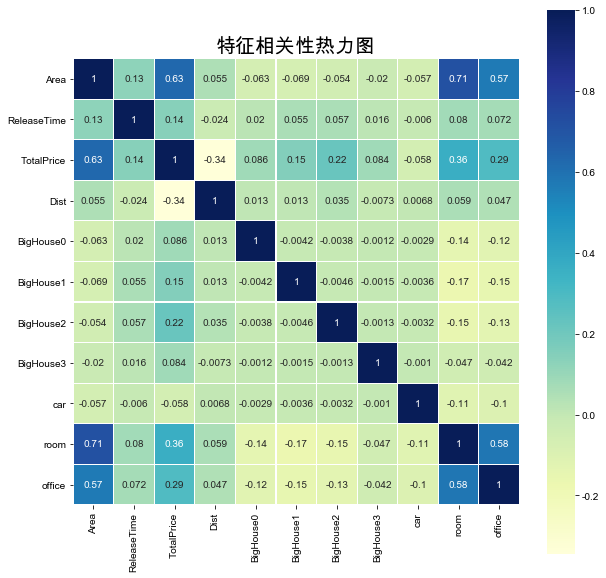

In [43]:
plt.figure(figsize=(10,10))
sns.heatmap(newdata.corr(),cmap="YlGnBu",linewidths=0.1,vmax=1.0,square=True,linecolor= 'white',annot=True)
plt.title('特征相关性热力图',size=20)
plt.show()

## 3.2 建立房价预测模型

In [44]:
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

import graphviz

from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

### 3.2.1 划分数据集

In [45]:
features = newdata.iloc[:,newdata.columns != 'TotalPrice']
target = newdata.iloc[:,newdata.columns == 'TotalPrice']

#划分数据集
features_train,features_test,target_train,target_test= train_test_split(features,target,test_size=0.2,random_state=25)

for i in [features_train,features_test,target_train,target_test]:
    i.index = range(i.shape[0])

### 3.2.2 决策树模型

#### 构建学习曲线

0.7474920578430166
0.5958855681638421


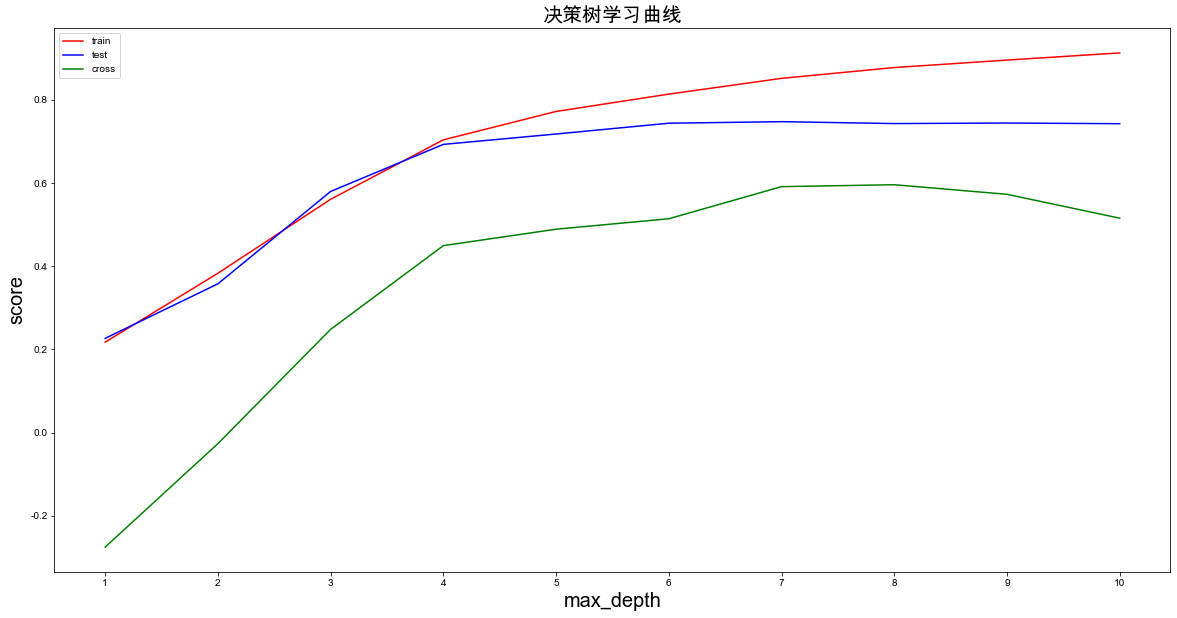

In [46]:
tr=[]
te=[]
tc=[]
N=10
for i in range(10):
    clf = DecisionTreeRegressor(random_state=25,max_depth=i+1,criterion='mse')
    clf=clf.fit(features_train,target_train)
    score_tr = clf.score(features_train,target_train)
    score_te = clf.score(features_test,target_test)
    score_tc = cross_val_score(clf,features,target,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    tc.append(score_tc)
    
print(max(te))  
print(max(tc))

plt.figure(figsize=(20,10))
plt.plot(range(1,N+1),tr,color='red',label='train')
plt.plot(range(1,N+1),te,color='blue',label='test')
plt.plot(range(1,N+1),tc,color='green',label='cross')
plt.xticks(range(1,N+1))
plt.legend()
plt.xlabel("max_depth",size=20)
plt.ylabel("score",size=20)
plt.title('决策树学习曲线',size=20)
plt.show()

#### 构建决策树模型

In [47]:
dt = DecisionTreeRegressor(max_depth=7,random_state=25)
dt=dt.fit(features_train,target_train)
print(f'训练集得分：{round(dt.score(features_train,target_train),5)}')
print(f'测试集得分：{round(dt.score(features_test,target_test),5)}')
print(f'交叉验证得分：{round(cross_val_score(dt,features,target.values.ravel(),cv=10).mean(),5)}')

训练集得分：0.85164
测试集得分：0.74749
交叉验证得分：0.59129


#### 决策树的可视化

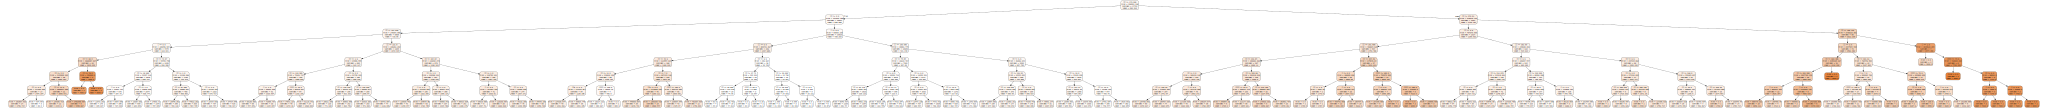

In [48]:
feature_name = ['面积','发布时间','区域','别墅0','别墅1','别墅2','别墅3','车库','室','厅']

import graphviz

dot_data = tree.export_graphviz(dt,out_file = None
                                ,feature_names = feature_name
                                ,class_names=['a','b','c']
                                ,filled=True
                                ,rounded=True)
graph = graphviz.Source(dot_data)
graph.save('./graph/tree.dot')
graph

### 3.2.3 随机森林模型

#### 绘制学习曲线

0.7902829499294328
0.6786903018193022


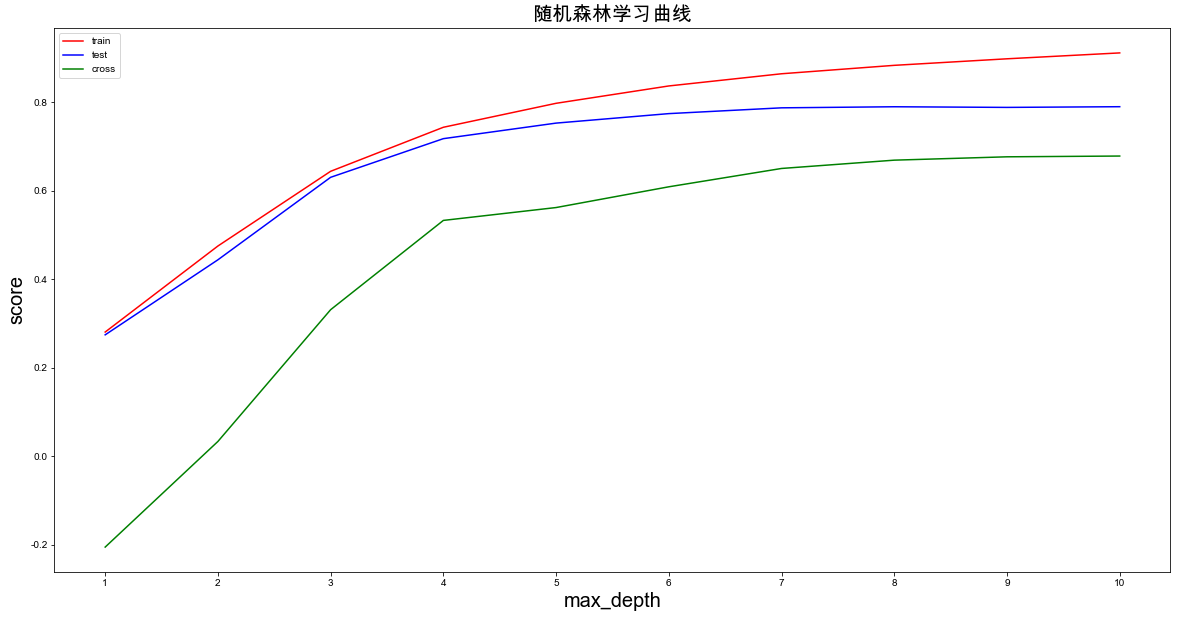

In [49]:
tr=[]
te=[]
tc=[]
N=10
for i in range(10):
    clf = RandomForestRegressor(random_state=25,max_depth=i+1,criterion='mse')
    clf=clf.fit(features_train,target_train.values.ravel())
    score_tr = clf.score(features_train,target_train)
    score_te = clf.score(features_test,target_test)
    score_tc = cross_val_score(clf,features,target.values.ravel(),cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
    tc.append(score_tc)
    
print(max(te)) 
print(max(tc))

plt.figure(figsize=(20,10))
plt.plot(range(1,N+1),tr,color='red',label='train')
plt.plot(range(1,N+1),te,color='blue',label='test')
plt.plot(range(1,N+1),tc,color='green',label='cross')
plt.xticks(range(1,N+1))
plt.legend()
plt.xlabel("max_depth",size=20)
plt.ylabel("score",size=20)
plt.title('随机森林学习曲线',size=20)
plt.show()

#### 构建随机森林模型

In [50]:
rf = RandomForestRegressor(n_estimators=100,max_depth=10)
rf.fit(features_train,target_train.values.ravel())
print(f'训练集得分：{round(rf.score(features_train,target_train),5)}')
print(f'测试集得分：{round(rf.score(features_test,target_test),5)}')
print(f'交叉验证得分：{round(cross_val_score(rf,features,target.values.ravel(),cv=10).mean(),5)}')

训练集得分：0.91171
测试集得分：0.79685
交叉验证得分：0.67545


### 3.2.4 k近邻模型

In [51]:
# k近邻
kn = KNeighborsRegressor(n_neighbors=20)
kn.fit(features_train,target_train)
print(f'训练集得分：{round(kn.score(features_train,target_train),5)}')
print(f'测试集得分：{round(kn.score(features_test,target_test),5)}')

训练集得分：0.605
测试集得分：0.57007


# 4 对模拟场景进行预测

## 4.1 构建模拟场景

In [52]:
apply = np.array([100,
                  30,
                  1,
                  0,0,0,0,
                  0,
                  2,2]).reshape(1,-1)

## 4.2 预测结果

In [53]:
print('------------总价预测结果-------------')
print(f'随机森林回归：{rf.predict(apply)[0]}万元')
print(f'决策树回归：{dt.predict(apply)[0]}万元')
print(f'K近邻回归：{kn.predict(apply)[0][0]}万元')
print('------------综合预测结果-------------')
print(((rf.predict(apply)+dt.predict(apply)+kn.predict(apply))/3.0)[0][0],'万元')

------------总价预测结果-------------
随机森林回归：977.1340749172954万元
决策树回归：957.7389162561576万元
K近邻回归：760.35万元
------------综合预测结果-------------
898.4076637244843 万元
